<a href="https://colab.research.google.com/github/kamranrauf75/CIFAR-10-Image-Classification/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project
### * Name Muhammad Kamran Rauf


## K-Nearest Neighbors (k-NN)
In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

You need to learn that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.


The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

`Note:`
You'll find these [notes on KNN](https://cs231n.github.io/classification/) useful- also available [here](https://github.com/cs231n/cs231n.github.io/blob/master/classification.md)

## Install starter code
We have implemented some utility functions for this exercise in the [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.



In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code


  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-auedpwf5
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-auedpwf5
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp37-none-any.whl size=10324 sha256=8282485937926ee7c7e9e38a52e3a7e41071f4a0dce23962afae916f991357d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbzlyyw0/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import coutils
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
The utility function `coutils.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [ ]:
x_train, y_train, x_test, y_test = coutils.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

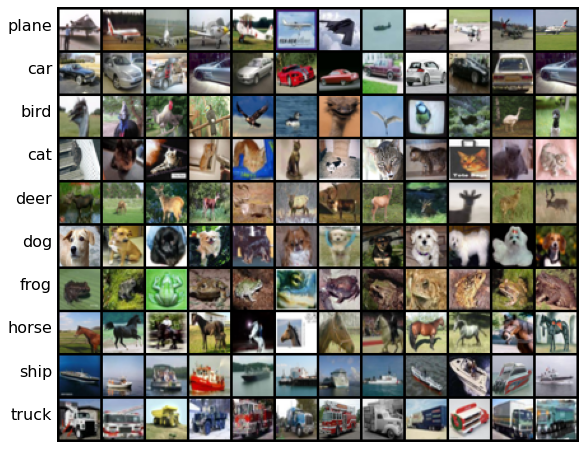

In [ ]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
  plt.text(-4, 34 * y + 18, cls, ha='right')
  idxs = (y_train == y).nonzero().view(-1)
  for i in range(samples_per_class):
    idx = idxs[random.randrange(idxs.shape[0])].item()
    samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(coutils.tensor_to_image(img))
plt.axis('off')
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `coutils.data.cifar10()` can automatically subsample the CIFAR10 dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

In [ ]:
help(coutils.data.cifar10)

Help on function cifar10 in module coutils.data:

cifar10(num_train=None, num_test=None)
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.
    
    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    
    Returns:
    - x_train: float32 tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: float32 tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)



We will subsample the data to use only 500 training examples and 100 test examples:

In [ ]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets:

**NOTE: When implementing distance functions in this notebook, you may not use the `torch.norm` function (or its instance method variant `x.norm`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

In [ ]:
def compute_distances_two_loops(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation uses a naive set of nested loops over the training and
  test data.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function using a pair of nested loops over the        #
  # training data and the test data.                                           #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  ##############################################################################
  # Replace "pass" statement with your code

  for i in range(num_test):
      for j in range(num_train):
        distance = (torch.sum(torch.square((x_train[j,:] - x_test[i,:]))))
        dists[j,i] = distance


  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

After implementing the function above, we can run it to check that it has the expected shape:

In [ ]:
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

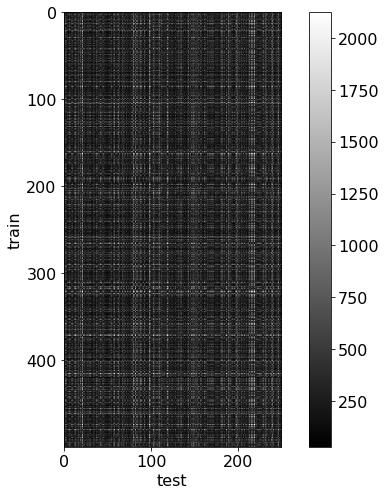

In [ ]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, complete the following implementation which uses only a single Python loop over the training data:

In [ ]:
def compute_distances_one_loop(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation uses only a single loop over the training data.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function using only a single loop over x_train.       #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  ##############################################################################
  # Replace "pass" statement with your code

  for i in range(num_train):
    distance = torch.sum(torch.square(x_train[i,:] - x_test),dim=(1,2,3))
    dists[i,:] = distance

  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [ ]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


Now implement a fully vectorized version of the distance computation function
that does not use any python loops.

In [ ]:
def compute_distances_no_loops(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation should not use any Python loops. For memory-efficiency,
  it also should not create any large intermediate tensors; in particular you
  should not create any intermediate tensors with O(num_train*num_test)
  elements.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function without using any explicit loops and without #
  # creating any intermediate tensors with O(num_train * num_test) elements.   #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  #                                                                            #
  # HINT: Try to formulate the Euclidean distance using two broadcast sums     #
  #       and a matrix multiply.                                               #
  ##############################################################################
  # Replace "pass" statement with your code

  d1 = x_train.reshape(num_train,-1)
  d2 = x_test.reshape(num_test,-1).T
  d3 = x_test.reshape(num_test,-1)
  distmulAB = 2 * (d1.mm(d2))
  aSquare = (torch.sum(torch.square(d1),dim = 1)).reshape(-1,1)
  bSquare = (torch.sum(torch.square(d3),dim = 1)).reshape(1,-1)
  dists = (aSquare + bSquare - distmulAB)

  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [ ]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  1.8902124902629952e-11
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [ ]:
import time

def timeit(f, *args):
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 5.00 seconds
One loop version took 1.06 seconds (4.7X speedup)
No loop version took 0.02 seconds (213.6X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

Complete the implementation of the function below:

In [ ]:
def predict_labels(dists, y_train, k=1):
  """
  Given distances between all pairs of training and test samples, predict a
  label for each test sample by taking a majority vote among its k nearest
  neighbors in the training set.

  In the event of a tie, this function should return the smaller label. For
  example, if k=5 and the 5 nearest neighbors to a test example have labels
  [1, 2, 1, 2, 3] then there is a tie between 1 and 2 (each have 2 votes), so
  we should return 1 since it is the smaller label.

  Inputs:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  - y_train: Torch tensor of shape (y_train,) giving labels for all training
    samples. Each label is an integer in the range [0, num_classes - 1]
  - k: The number of nearest neighbors to use for classification.

  Returns:
  - y_pred: A torch int64 tensor of shape (num_test,) giving predicted labels
    for the test data, where y_pred[j] is the predicted label for the jth test
    example. Each label should be an integer in the range [0, num_classes - 1].
  """
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)
  ##############################################################################
  # TODO: Implement this function. You may use an explicit loop over the test  #
  # samples. Hint: Look up the function torch.topk                             #
  ##############################################################################
  # Replace "pass" statement with your code

  for i in range(num_test):
    _,indices = torch.topk(dists[:,i],k,largest=False)
    num = torch.bincount(y_train[indices])
    y_pred[i] = torch.argmax(num)

  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return y_pred

Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. We can define a simple object to encapsulate the classifier:

In [ ]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    """
    Create a new K-Nearest Neighbor classifier with the specified training data.
    In the initializer we simply memorize the provided training data.

    Inputs:
    - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
    - y_train: int64 torch tensor of shape (num_train,) giving training labels
    """
    self.x_train = x_train.contiguous()
    self.y_train = y_train.contiguous()

  def predict(self, x_test, k=1):
    """
    Make predictions using the classifier.

    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - k: The number of neighbors to use for predictions

    Returns:
    - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
      for the test samples.
    """
    dists = compute_distances_no_loops(self.x_train, x_test.contiguous())
    y_test_pred = predict_labels(dists, self.y_train, k=k)
    return y_test_pred

  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    """
    Utility method for checking the accuracy of this classifier on test data.
    Returns the accuracy of the classifier on the test data, and also prints a
    message giving the accuracy.

    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - y_test: int64 torch tensor of shape (num_test,) giving test labels
    - k: The number of neighbors to use for prediction
    - quiet: If True, don't print a message.

    Returns:
    - accuracy: Accuracy of this classifier on the test data, as a percent.
      Python float in the range [0, 100]
    """
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [ ]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

In [ ]:
classifier.check_accuracy(x_test, y_test, k=5)

Got 139 / 500 correct; accuracy is 27.80%


27.8

## `Congratulations! This is the end of assignment 2`